<a href="https://colab.research.google.com/github/mipypf/practical-mi-guide/blob/develop/chapter4/src/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 画像分類のタスクを実行
### 使用するデータセットの参考文献
 - https://publikationen.bibliothek.kit.edu/1000133819
 - https://github.com/2Obe/BSData
 - https://www.sciencedirect.com/science/article/pii/S2352340921009185?via%3Dihub

## Google colabを使用の場合、ランタイムのタブから「ランタイムのタイプを変更」→ハードウェアアクセラレータと進み、T4 GPUを選択

In [1]:
# 以下のコマンドでGPUが使用可能かを確認
! nvidia-smi

Tue Jan 21 09:43:02 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## データセットのダウンロード
- https://publikationen.bibliothek.kit.edu/1000133819 のDownloadボタンをクリックし、遷移先から規約を確認してデータセット10.35097-1511.tarをダウンロード

## Google Colabの準備

In [2]:
# Google Colabを利用する場合はTrue、そうでない場合はFalseとする
colab = True

In [3]:
# Google Colabのファイルをクリックし、10.35097-1511.tarをドラッグ＆ドロップしてアップロード
# 10.35097-1511.tarを以下のコマンドで解凍する
!tar -xvf 10.35097-1511.tar

10.35097-1511/
10.35097-1511/data/
10.35097-1511/data/readme.txt
10.35097-1511/data/descriptive-md/
10.35097-1511/data/descriptive-md/dataset.desc_md.xml
10.35097-1511/data/technical-md/
10.35097-1511/data/technical-md/dataset.tech_md.xml
10.35097-1511/data/dataset/
10.35097-1511/data/dataset/training_data.zip
10.35097-1511/bagit.txt
10.35097-1511/manifest-md5.txt
10.35097-1511/bag-info.txt
10.35097-1511/tagmanifest-md5.txt


In [4]:
if colab:
  INPUT_FILE_PATH = "./"
  OUTPUT_FILE_PATH = "./"
else:
  INPUT_FILE_PATH = "../input/"
  OUTPUT_FILE_PATH = "../output/"

In [5]:
import zipfile

# training_data.zipファイルを解凍する
with zipfile.ZipFile(INPUT_FILE_PATH + "10.35097-1511/data/dataset/training_data.zip", "r") as zip_ref:
    zip_ref.extractall(INPUT_FILE_PATH)

## ライブラリをインポート

In [6]:
import gc
import glob
import os
import pickle
import random
import sys
import warnings

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import confusion_matrix
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import (
    CosineAnnealingLR,
    CosineAnnealingWarmRestarts,
    LambdaLR,
    OneCycleLR,
    ReduceLROnPlateau,
    StepLR,
)
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from tqdm.notebook import tqdm

tqdm.pandas()

import cv2
import imageio
import sklearn.exceptions
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [7]:
# pytorchのverを確認
print(torch.__version__)

2.5.1+cu121


## random seed、デバイスの設定

In [8]:
# seedの固定
def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything()

# デバイスの設定
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


## 画像の読み込みと表示

In [9]:
# 画像のパスを取得(ローカル環境で実行の場合は、training_data.zipを解凍したtraining_dataのディレクトリをINPUT_FILE_PATH配下に格納)
train_path = (
    INPUT_FILE_PATH + "training_data"
)
train_files = sorted(glob.glob(os.path.join(train_path, "*.png")))
print(f"Train data: {len(train_files)}")

Train data: 21835


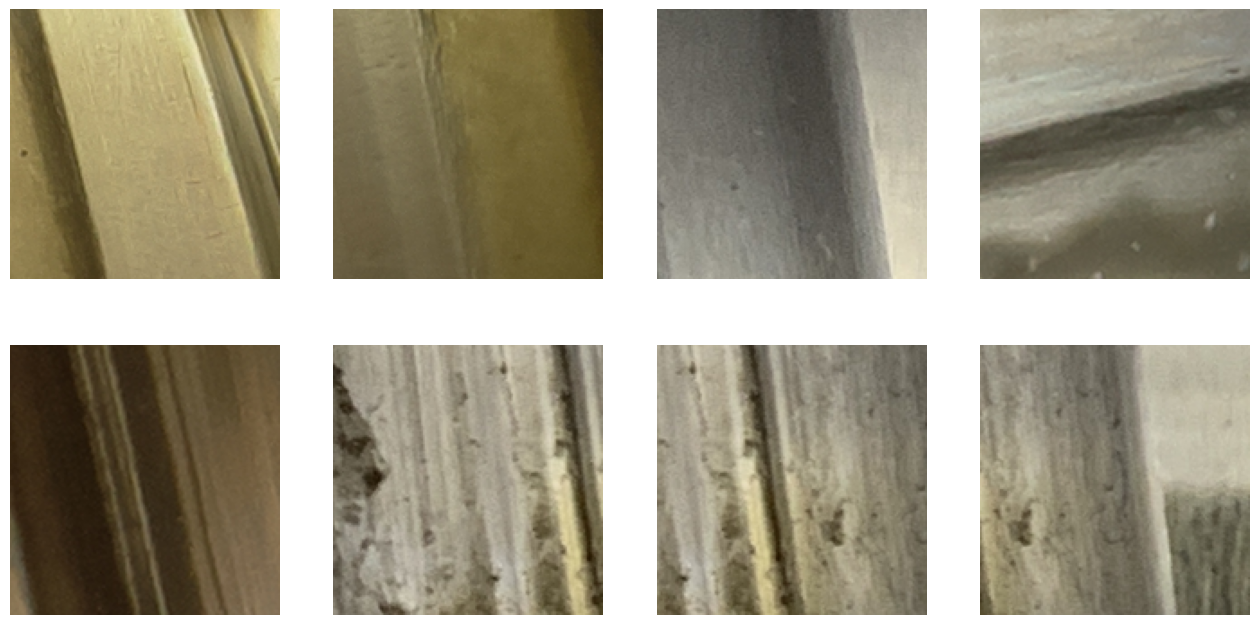

In [10]:
# train_filesでファイル名がNで始まる画像をランダムに表示
plt.figure(figsize=(16, 8))
for i, file in enumerate(train_files[:8]):
    if "N" in file:
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 4, i + 1)
        plt.imshow(image)
        plt.axis("off")
plt.show()

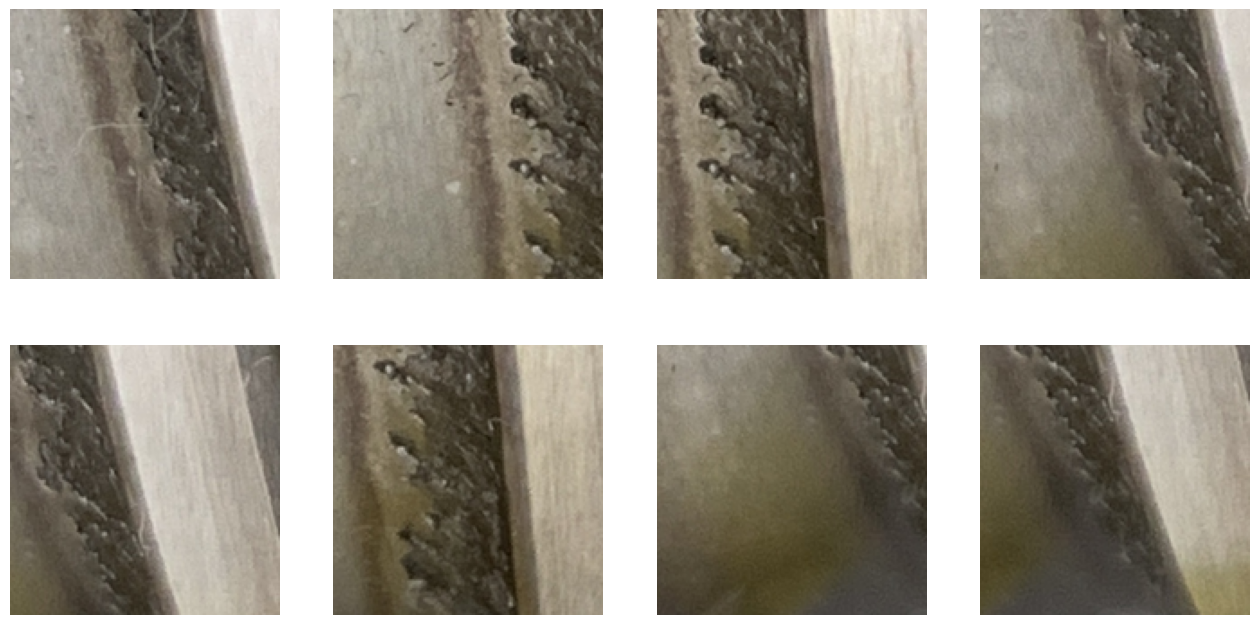

In [11]:
# train_filesでファイル名がPで始まる画像を後ろから表示
plt.figure(figsize=(16, 8))
for i, file in enumerate(train_files[-8:]):
    if "P" in file:
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 4, i + 1)
        plt.imshow(image)
        plt.axis("off")
plt.show()

## データを学習データ、検証データに分割

In [12]:
# 画像のファイル名にPあるものは1, Nがあるものは0としてラベルを付与してtimmのモデルで2値分類を行う
train_df = pd.DataFrame(train_files, columns=["file_path"])
train_df["label"] = train_df["file_path"].apply(lambda x: 1 if "P" in x else 0)

# train_dfをサンプリング
train_df = train_df.sample(frac=0.03, random_state=42).reset_index(drop=True)

# train_dfを学習データと検証データに分割
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_index, valid_index) in enumerate(
    skf.split(train_df, train_df["label"])
):
    train_df.loc[valid_index, "fold"] = fold
train_df["fold"] = train_df["fold"].astype(int)

train_df

,file_path,label,fold
0,./training_data/N (2367).png,0,3
1,./training_data/P (2155).png,1,0
2,./training_data/N (9823).png,0,0
3,./training_data/P (7299).png,1,4
4,./training_data/P (8120).png,1,2
...,...,...,...
650,./training_data/P (4807).png,1,2
651,./training_data/N (7624).png,0,3
652,./training_data/N (959)_.png,0,4
653,./training_data/P (346).png,1,0


## 画像分類モデルの構築

In [13]:
# データセットの作成
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.df["file_path"].values[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(
            image, cv2.COLOR_BGR2RGB
        )  # cv2.imreadで読み込んだ画像はBGRで読み込まれるため、RGBに変換する。pilowで画像を読み込む場合は、変換の必要はない。
        if self.transform:
            image = self.transform(image=image)["image"]
        label = self.df["label"].values[idx]
        return image, label


# データ拡張の設定
transform = A.Compose(
    [
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.Normalize(),
        ToTensorV2(),
    ] # 学習データにはデータ拡張を行う
)

valid_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(), ToTensorV2()]
)  # 検証データにはデータ拡張を行わず、リサイズと正規化のみを行う。

# データセットの作成（今回はfold0を検証データ、それ以外を学習データとしてSingle holdでの検証としている）
train_dataset = ImageDataset(train_df[train_df["fold"] != 0], transform=transform)
valid_dataset = ImageDataset(train_df[train_df["fold"] == 0], transform=valid_transform)

# データローダーの作成
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)  # shuffle=Trueに設定すると、エポックごとに訓練データがランダムにシャッフルされる。これにより、モデルが訓練データを学習する順序が毎回異なり、過学習を防ぐ効果がある。
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False
)  # shuffle=Falseに設定すると、データがシャッフルされない。検証データはシャッフルする必要がないため、Falseに設定する。

# モデルの作成
model = timm.create_model(
    "resnet18", pretrained=False, num_classes=1
)  # num_clases=1として2値分類を行うため、最終層の出力ユニット数を1に設定する。
model = model.to(device)

# 損失関数の設定
criterion = nn.BCEWithLogitsLoss()

# オプティマイザの設定
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# 学習率スケジューラの設定
num_epochs = 50
scaler = GradScaler()
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

# モデル保存のための初期化
best_valid_loss = float("inf")
save_path = "best_model.pth"

# 損失を記録するリスト
train_losses = []
valid_losses = []

# 学習の実行
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device).float().view(-1, 1)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # 検証ループ
    model.eval()
    valid_running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader):
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
    valid_loss = valid_running_loss / len(valid_loader)
    valid_losses.append(valid_loss)

    # 改善された場合にモデルを保存
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
        print(f"Model saved at epoch {epoch+1} with validation loss {valid_loss:.4f}")

    print(
        f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}"
    )

    # スケジューラのステップ
    scheduler.step()

print(f"Best validation loss: {best_valid_loss:.4f}, Model saved to {save_path}")

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 1 with validation loss 0.6859
Epoch: 1/50, Train Loss: 0.6656, Valid Loss: 0.6859


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 2/50, Train Loss: 0.6062, Valid Loss: 0.6978


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3/50, Train Loss: 0.5811, Valid Loss: 0.7276


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 4/50, Train Loss: 0.5491, Valid Loss: 0.7173


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 5 with validation loss 0.6447
Epoch: 5/50, Train Loss: 0.5212, Valid Loss: 0.6447


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 6 with validation loss 0.5711
Epoch: 6/50, Train Loss: 0.5255, Valid Loss: 0.5711


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 7 with validation loss 0.5092
Epoch: 7/50, Train Loss: 0.5032, Valid Loss: 0.5092


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 8 with validation loss 0.4895
Epoch: 8/50, Train Loss: 0.4925, Valid Loss: 0.4895


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 9 with validation loss 0.4328
Epoch: 9/50, Train Loss: 0.4965, Valid Loss: 0.4328


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 10 with validation loss 0.4116
Epoch: 10/50, Train Loss: 0.4641, Valid Loss: 0.4116


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 11 with validation loss 0.4012
Epoch: 11/50, Train Loss: 0.4360, Valid Loss: 0.4012


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 12 with validation loss 0.3967
Epoch: 12/50, Train Loss: 0.4387, Valid Loss: 0.3967


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 13 with validation loss 0.3697
Epoch: 13/50, Train Loss: 0.4264, Valid Loss: 0.3697


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14/50, Train Loss: 0.4295, Valid Loss: 0.4402


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 15 with validation loss 0.3638
Epoch: 15/50, Train Loss: 0.4005, Valid Loss: 0.3638


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 16 with validation loss 0.3530
Epoch: 16/50, Train Loss: 0.3894, Valid Loss: 0.3530


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 17 with validation loss 0.3404
Epoch: 17/50, Train Loss: 0.3718, Valid Loss: 0.3404


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 18 with validation loss 0.3303
Epoch: 18/50, Train Loss: 0.3993, Valid Loss: 0.3303


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19/50, Train Loss: 0.3922, Valid Loss: 0.3381


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20/50, Train Loss: 0.3584, Valid Loss: 0.3375


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 21 with validation loss 0.3071
Epoch: 21/50, Train Loss: 0.4133, Valid Loss: 0.3071


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22/50, Train Loss: 0.3703, Valid Loss: 0.3382


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23/50, Train Loss: 0.3751, Valid Loss: 0.3076


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 24 with validation loss 0.2976
Epoch: 24/50, Train Loss: 0.3654, Valid Loss: 0.2976


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25/50, Train Loss: 0.3551, Valid Loss: 0.3017


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 26 with validation loss 0.2942
Epoch: 26/50, Train Loss: 0.3706, Valid Loss: 0.2942


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27/50, Train Loss: 0.3217, Valid Loss: 0.3106


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28/50, Train Loss: 0.3514, Valid Loss: 0.3356


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29/50, Train Loss: 0.3306, Valid Loss: 0.3002


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 30 with validation loss 0.2893
Epoch: 30/50, Train Loss: 0.3285, Valid Loss: 0.2893


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31/50, Train Loss: 0.3149, Valid Loss: 0.2998


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 32 with validation loss 0.2797
Epoch: 32/50, Train Loss: 0.3159, Valid Loss: 0.2797


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 33 with validation loss 0.2728
Epoch: 33/50, Train Loss: 0.2901, Valid Loss: 0.2728


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34/50, Train Loss: 0.2888, Valid Loss: 0.2730


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 35 with validation loss 0.2659
Epoch: 35/50, Train Loss: 0.3012, Valid Loss: 0.2659


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36/50, Train Loss: 0.2822, Valid Loss: 0.2677


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37/50, Train Loss: 0.3184, Valid Loss: 0.2722


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38/50, Train Loss: 0.2880, Valid Loss: 0.2879


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 39 with validation loss 0.2608
Epoch: 39/50, Train Loss: 0.3020, Valid Loss: 0.2608


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40/50, Train Loss: 0.2936, Valid Loss: 0.2643


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 41/50, Train Loss: 0.2795, Valid Loss: 0.2623


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 42/50, Train Loss: 0.3019, Valid Loss: 0.2663


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 43/50, Train Loss: 0.3060, Valid Loss: 0.2655


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 44/50, Train Loss: 0.3035, Valid Loss: 0.2654


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 45/50, Train Loss: 0.2915, Valid Loss: 0.2764


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 46/50, Train Loss: 0.2875, Valid Loss: 0.2717


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 47/50, Train Loss: 0.2914, Valid Loss: 0.2664


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 48/50, Train Loss: 0.2794, Valid Loss: 0.2667


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 49/50, Train Loss: 0.2858, Valid Loss: 0.2694


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 50/50, Train Loss: 0.2947, Valid Loss: 0.2666
Best validation loss: 0.2608, Model saved to best_model.pth


## 構築したモデルの評価

In [14]:
# 検証データにおける正解率とF1スコアを計算
valid_preds = []
valid_labels = []
model.eval()
with torch.no_grad():
    for images, labels in tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device).float().view(-1, 1)
        outputs = model(images)
        preds = torch.sigmoid(outputs).cpu().numpy()
        valid_preds.extend(preds)
        valid_labels.extend(labels.cpu().numpy())
valid_preds = np.array(valid_preds).flatten()

  0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
# valid_predsとvalid_labelsを比較して、scikit-learnのモジュールを使用して正解率とF1スコアを計算
valid_preds = np.where(valid_preds > 0.5, 1, 0)
valid_labels = np.array(valid_labels).flatten()
accuracy = accuracy_score(valid_labels, valid_preds)
f1 = f1_score(valid_labels, valid_preds)
print(f"Accuracy: {accuracy:.2f}, F1: {f1:.2f}")

Accuracy: 0.89, F1: 0.88


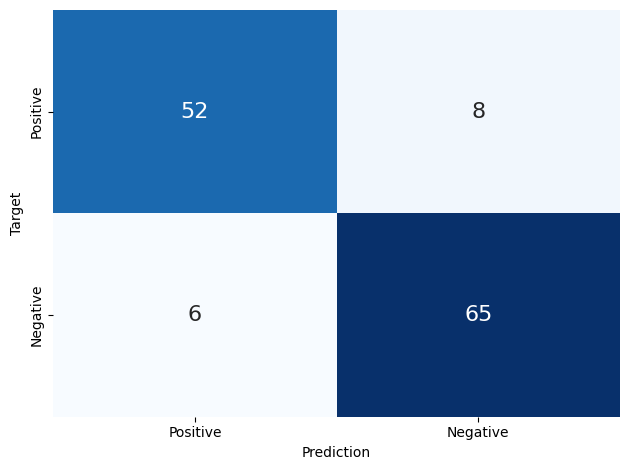

In [16]:
# confusion matrixを左上がTrue Positive、右上がFalse Positive、左下がFalse Negative、右下がTrue Negativeになるように可視化
cm = confusion_matrix(valid_labels, valid_preds)
sns.heatmap(
    cm[::-1, ::-1],
    annot=True,
    cmap="Blues",
    fmt="d",
    cbar=False,
    annot_kws={"size": 16},
)
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.xticks([0.5, 1.5], ["Positive", "Negative"])
plt.yticks([0.5, 1.5], ["Positive", "Negative"])
plt.tight_layout()
plt.show()